# Comparison of SolarFarmer and NIST Testbed
For PVSC-45 and WCPEC-7 joint conference in Waikoloa, Hawaii, HI, USA, on June 10-15, 2018.

## Introduction
This notebook compares SolarFarmer results to measurements from the [NIST PV Testbed](https://www.nist.gov/el/energy-and-environment-division-73200/heat-transfer-alternative-energy-systems/photovoltaic-0) in Gaithersburg, MD. The validation uses plots of `y = x`, mean bias error (MBE), and root mean bias error (RMSE).

## Requirements
To use this notebook, run the SolarFarmer workbook (link) for the NIST ground array and then copy the SolarFarmer `Testing` folder to the path specified in the **Set Up** section below. Make sure the date format is correct, and use `dayfirst` to convert EU time to American. Also copy the NIST ground array and weather station output data into a CSV file and specify its path.

## NIST data
Data for the NIST weather station and ground array can be downloaded from [NIST PV data page](https://pvdata.nist.gov) for 2017. Use this script (link) to create an input weather file for SolarFarmer, and an output file for comparison. The script filters out any times with zenith below the horizon, set arbitrarily at 90&deg;, any times with negative measured global horizontal irradiance (GHI) or diffuse horizontal irradiance (DHI) from the weather station, or any times with negative measured AC or DC power at the inverter from the ground array. Then the data is averaged hourly with timestamps at the beginning of each hour. Any time with missing data is dropped. This data is then used to make the weather input file for SolarFarmer, called "NIST_weather_hourly.txt, which is tab separated, and contains columns for measured hourly GHI, DHI (called "DIF"), air temperature (called "Temp"), and wind speed (called "WS"). The data is also used to create a CSV file with measured hourly AC and DC power output called "NIST_ground_hourly.csv".

In [1]:
# this cell sets up inline plots and imports some packages

# make inline plots
%matplotlib inline

# imports
import os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# set seaborn context, font scale, color palette, and figure size
sns.set_context('notebook')
sns.set(font_scale=1.5)
sns.set_palette(sns.color_palette("hls", 20))
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

In [3]:
# this cell defines a function to add a y=x line to plots that spans the given
# x-y data

def xyline(xdata, ydata):
    """given x and y data, return the endpoints of the y=x line"""
    xypts = min(xdata.min(), ydata.min()), max(xdata.max(), ydata.max())
    return xypts, xypts

## Set Up
In order to read in the files we need to get some information. Fill in the `CONSTANTS` below

In [4]:
# set the name of the PVSyst output file here:
NIST_OUTPUT_FILE = 'NIST_ground_hourly.csv'
EASTERN_TZ = 'Etc/GMT+5'

# set the name of the test site to use in plots here:
TEST_SITE = 'NIST Testbed'

# set the full path to the SolarFarmer "Testing" folder here:
TEST_SITE_PATH = os.path.abspath(
    os.path.expandvars(os.path.expanduser(
        os.path.join(
            '~', 'OneDrive', 'OneDrive - DNV GL', 'SolarFarmer', 'Validation',
            'NIST_Testbed'
        )
    ))
)

# set the rated AC power of the inverter for scaling the differences between SolarFarmer and PVSyst
PAC_RATED = 260e3  # [W]

In [5]:
# CONSTANTS, PATHS, and FILENAMES
SF_TESTING = os.path.join(TEST_SITE_PATH, 'Testing')
SF_AC_LOSSES = os.path.join(SF_TESTING, 'AC_Losses.tsv')
SF_IRRADIANCE = os.path.join(SF_TESTING, 'irradiance.tsv')
SF_IRRAD_NAMES = [
    'Sun Azimuth', 'Sun Zenith', 'GI', 'Direct POA', 'Diffuse POA',
    'Reflected POA', 'Global Shaded Irradiance'
]
SF_INVERTER = os.path.join(SF_TESTING, 'inverter.tsv')
SF_INVERTER_NAMES = [
    'Time', 'Input Voltage', 'Input Power', 'Output Power',
    'InverterEfficiency'
]
SF_LOSSTREE = os.path.join(SF_TESTING, 'LossTreeResults.tsv')
SF_LOSSTREE_NAMES = [
    'AmbientTemperature', 'WindSpeed', 'GHI', 'DHI',
    'GlobalEffectiveIrradiance', 'NearShadingIrradiance',
    'SoilingLossIrradiance', 'SpectralIrradiance', 'ShadedIrradiance',
    'IAM Effect (%)', 'Mean Cell Temperature', 'NominalPower',
    'ModelledPowerAtSTC', 'STCPower', 'TemperaturePower',
    'Temperature Effect (%)', 'IrradiancePower', 'Irradiance Effect (%)',
    'PowerBinningPower', 'LightInducedDegredationPower',
    'ModuleQualityPower', 'ModuleMismatchPower', 'ElectricalMismatchPower',
    'OhmicDcPower', 'InverterMinDcVoltagePower', 'InverterMaxAcPowerPower',
    'InverterMaxDcCurrentPower', 'InverterMaxDcVoltagePower',
    'InverterMinDcPowerPower', 'InverterEfficiencyPower',
    'InverterTarePower', 'Inverter Total Effect (%)', 'OhmicAcPower',
    'TransformerPower', 'AvailabilityPower'
]
NIST_OUTPUT = os.path.join(TEST_SITE_PATH, NIST_OUTPUT_FILE)

In [6]:
# read PVSyst CSV file
nist_output = pd.read_csv(NIST_OUTPUT, index_col='TIMESTAMP', parse_dates=True)

# read SolarFarmer CSV files
sf_inverter = pd.read_csv(
    SF_INVERTER, delimiter='\t', skiprows=3, names=SF_INVERTER_NAMES,
    parse_dates=True, index_col='Time')
sf_irradiance = pd.read_csv(SF_IRRADIANCE, delimiter='\t')
sf_losstree = pd.read_csv(SF_LOSSTREE, delimiter='\t', parse_dates=True,
                          index_col='Time')

In [7]:
# adjust NIST azimuth to same convention as SolarFarmer
nist_output.AZ += 180.0
# fix NIST timezone
nist_output.index = nist_output.index.tz_localize('UTC').tz_convert(EASTERN_TZ)

# adjust SolarFarmer irradiance units from suns to W/m^2
E0 = 1000.0  # W/m^2
sf_irradiance.GI *= E0
sf_irradiance['Direct POA'] *= E0
sf_irradiance['Diffuse POA'] *= E0
sf_irradiance['Reflected POA'] *= E0
sf_irradiance['Global Shaded Irradiance'] *= E0
sf_losstree.GHI *= E0
sf_losstree.DHI *= E0
sf_losstree.GlobalEffectiveIrradiance *= E0
sf_losstree.NearShadingIrradiance *= E0
sf_losstree.SoilingLossIrradiance *= E0
sf_losstree.SpectralIrradiance *= E0
sf_losstree.ShadedIrradiance *= E0

# calculate inverter efficiency and set year to 1990
sf_inverter['InverterEfficiency'] = (
    sf_inverter['Output Power'] / sf_inverter['Input Power']
)

# offset times to match NIST
sf_inverter.index = (sf_inverter.index.tz_localize(EASTERN_TZ)
                     - pd.DateOffset(hours=(+0.5)))
sf_losstree.index = (sf_losstree.index.tz_localize(EASTERN_TZ)
                     - pd.DateOffset(hours=(+0.5)))

# SF inverter and irradiance have the same index
sf_irradiance.index = sf_inverter.index

In [8]:
# combine the data
comparison = pd.concat(
    [sf_inverter, sf_irradiance[SF_IRRAD_NAMES],
     sf_losstree[SF_LOSSTREE_NAMES], nist_output],
    axis=1, 
)

# remove times when inverter efficiency is undefined and unmatched
# times between PVSyst and SolarFarmer
comparison = comparison.dropna()

comparison = comparison[comparison.PAC_GND>0]
comparison = comparison[comparison.PDC_GND>0]

# remove clipped power
clipped = comparison['Output Power'] < PAC_RATED
num_unclipped = clipped.size
print('Number of timesteps unclipped: {:d}'.format(num_unclipped))
num_clipped = clipped.astype(int).sum()
print('Number of timesteps clipped: {:d}'.format(num_clipped))
clip_diff = num_unclipped - num_clipped
print('Number of timesteps removed: {:d}'.format(clip_diff))
comparison = comparison[clipped]

# add months and days
comparison['month'] = comparison.index.month
comparison['hour'] = comparison.index.hour
comparison['doy'] = comparison.index.dayofyear

Number of timesteps unclipped: 4006
Number of timesteps clipped: 4005
Number of timesteps removed: 1


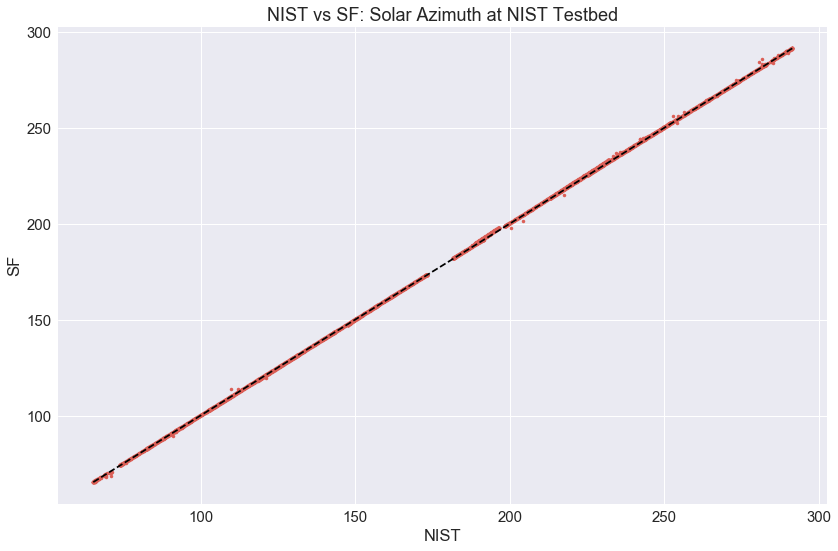

In [9]:
# plot comparison of solar azimuth
xdata = comparison.AZ
ydata = comparison['Sun Azimuth']
plt.plot(xdata, ydata, '.')
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: Solar Azimuth at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()

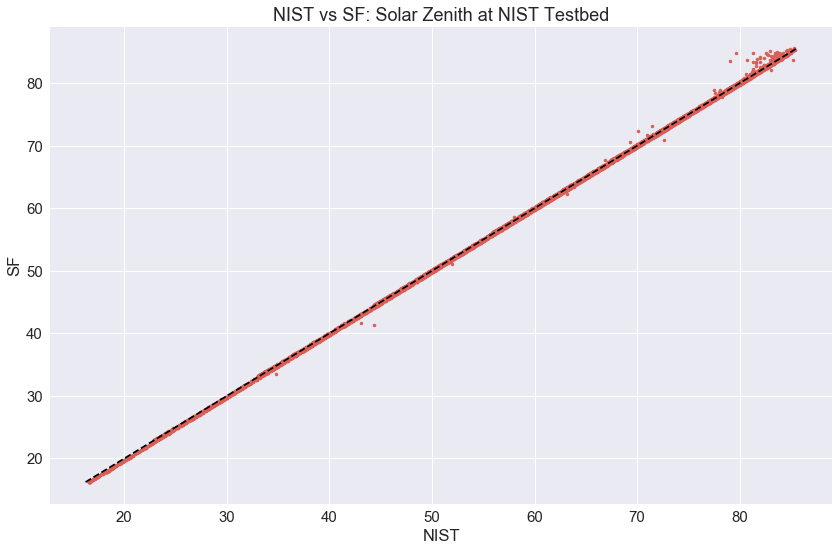

In [10]:
# plot comparison of solar zenith
xdata = comparison.ZE
ydata = comparison['Sun Zenith']
plt.plot(xdata, ydata, '.')
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: Solar Zenith at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()

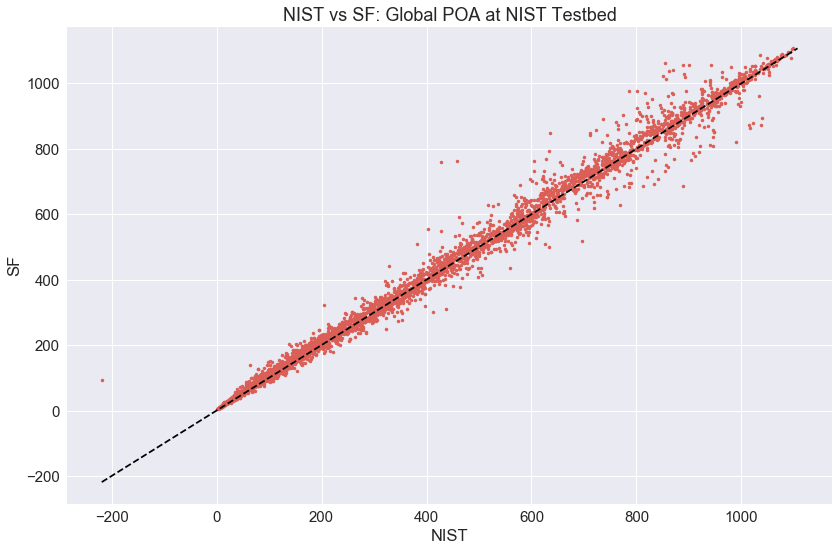

In [11]:
# plot comparison of global POA
xdata = comparison.POA_GND
ydata = comparison['GI']
plt.plot(xdata, ydata, '.')
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: Global POA at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()

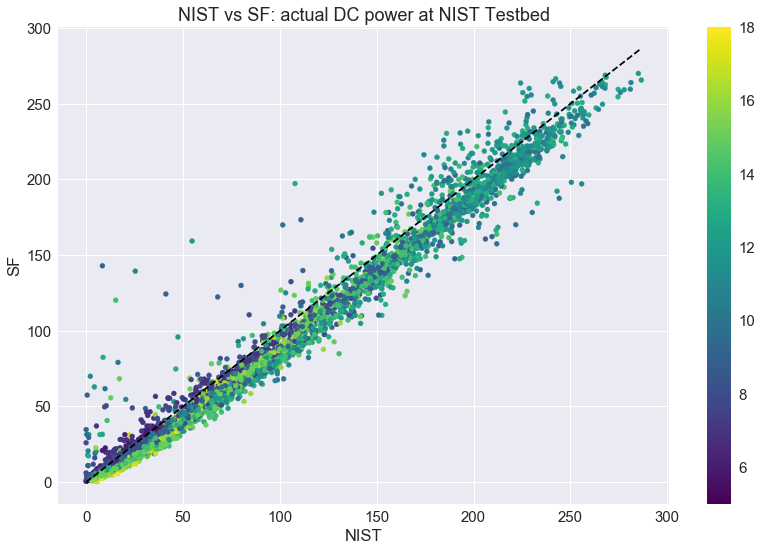

In [12]:
# plot comparison of inverter input power
xdata = comparison.PDC_GND
ydata = comparison['Input Power'] / 1000.0
plt.scatter(xdata, ydata, 25, comparison.hour, cmap='viridis')
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: actual DC power at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()
plt.colorbar()

In [13]:
# plot comparison of array temperature
# xdata = comparison.RTD_GND
# ydata = comparison['Mean Cell Temperature'] 
# plt.plot(xdata, ydata, '.')
# # plot y=x line
# plt.plot(*xyline(xdata, ydata), 'r--')
# plt.title('NIST vs SF: cell temperature at %s' % TEST_SITE)
# plt.xlabel('NIST')
# plt.ylabel('SF')
# plt.tight_layout()

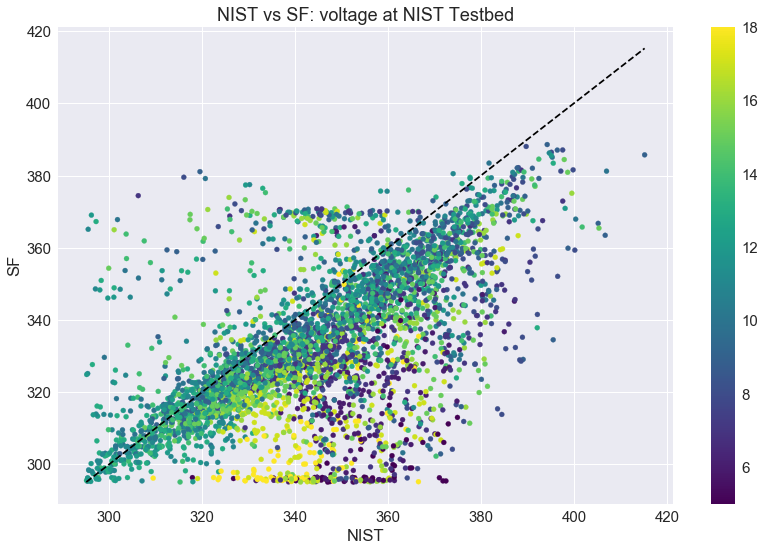

In [14]:
# plot comparison of inverter input voltage
xdata = comparison.VDC_GND
ydata = comparison['Input Voltage']
plt.scatter(xdata, ydata, 25, comparison.hour, cmap='viridis')
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: voltage at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()
plt.colorbar()

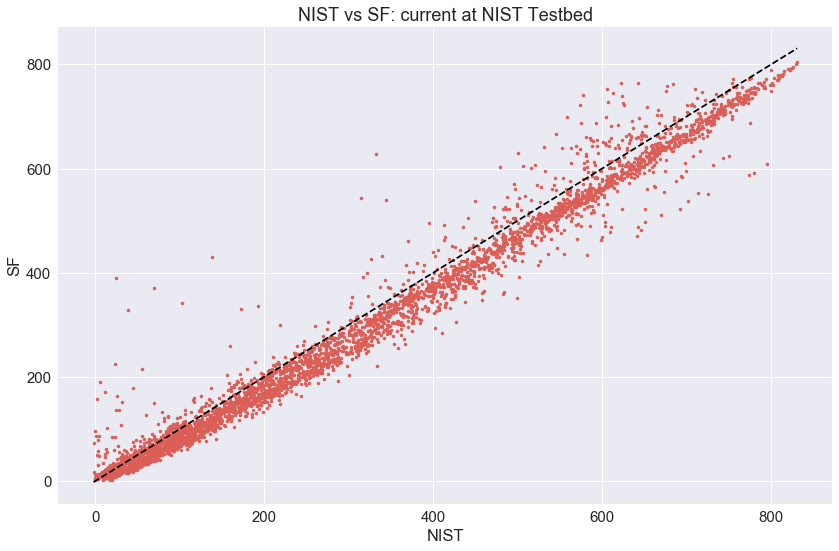

In [15]:
# plot comparison of inverter input current
xdata = comparison.IDC_GND
ydata = comparison['Input Power'] / comparison['Input Voltage']
plt.plot(xdata, ydata, '.')
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: current at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()

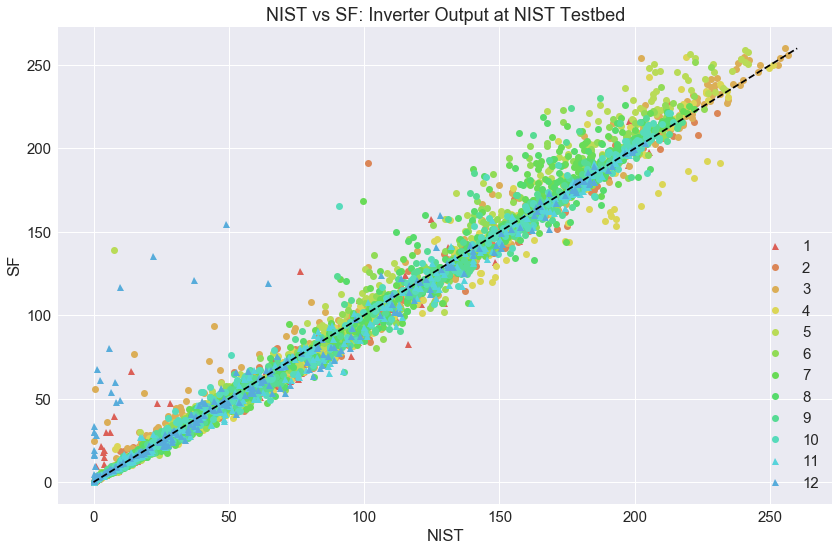

In [16]:
# plot comparison of inverter output
xdata = comparison.PAC_GND
ydata = comparison['Output Power'] / 1000.0
for m in range(12):
    midx = comparison.month == (m+1)
    plt.plot(xdata[midx], ydata[midx], 'o' if m not in [0, 10, 11] else '^')
# markersize=2, markeredgewidth=1, markerfacecolor='None'
plt.legend(range(1, 13))
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: Inverter Output at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()

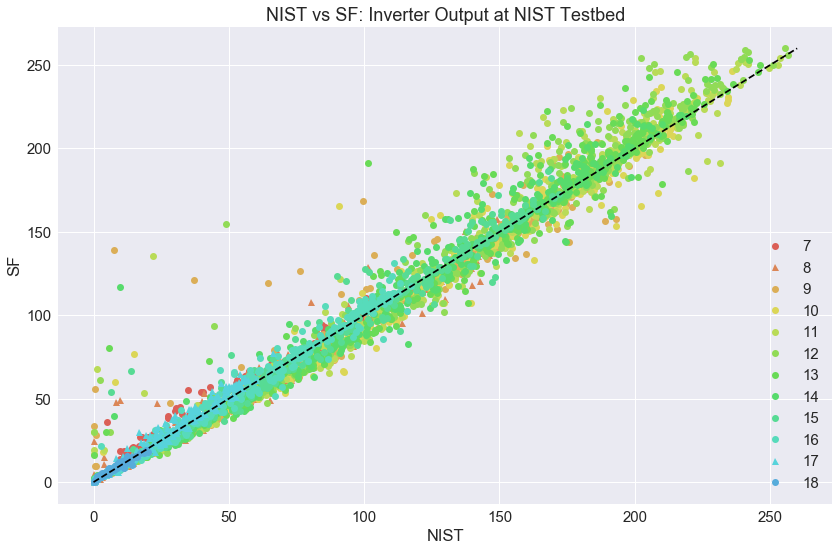

In [17]:
# plot comparison of inverter output
xdata = comparison.PAC_GND
ydata = comparison['Output Power'] / 1000.0
for h in range(6, 18):
    hidx = comparison.hour == (h+1)
    plt.plot(xdata[hidx], ydata[hidx], 'o' if h not in [7, 16] else '^')
plt.legend(range(7, 19))
# plot y=x line
plt.plot(*xyline(xdata, ydata), 'k--')
plt.title('NIST vs SF: Inverter Output at %s' % TEST_SITE)
plt.xlabel('NIST')
plt.ylabel('SF')
plt.tight_layout()

## Mean Bias and RMS between SolarFarmer and PVSyst
Let's calculate some metrics to quantify the difference between SolarFarmer and PVSyst:

### Bias
The bias, $\Delta$, is the difference between SolarFarmer and PVsyst predictions:

$$\Delta P_{ac} = P_{ac,SolarFarmer} - P_{ac, PVSyst}$$

According to this defnition, the bias is positive if SolarFarmer predicts more than PVSyst and negative otherwise.

### Mean Bias or MBE
If we aggregate the biases then we can calculate the mean bias, MBE. Note the "E" stands for "Error" but in this particular case, we don't know which prediction is correct, so we drop the term "Error" since it is misleading.

$$\text {MBE} = \frac{\sum^{N}_{n=0}{\Delta}}{N}$$

So we can calculate the annual MBE by averaging all biases over the whole year, the monthly or seasonal MBE by just averaging the biases from each month separately, or the diurnal or hourly MBE by average all of the predictions for the same hour, _e.g._: all of the 7AM(s), all of the 8AM(s), _etc_.

## Root Mean Square or RMSE
The bias tells how different the two predictions are, but the RMSE tells the _spread_ of the difference. Note the "E" stands for "Error" but in this particular case, we don't know which prediction is correct, so we drop the term "Error" since it is misleading. Unlike the bias, the RMSE is always possitive, which is an important difference. For example, the MBE might contain a mix of positive and negative biases which cancel out, yielding a low average, whereas the RMSE will increase to show that there is a _spread_ of positive and negative values. The bias is squared to get the RMS to be positive, then the RMS is just the square root of the average.

$$\text {RMSE} = \sqrt{\frac{\sum^{N}_{n=0}{\Delta^2}}{N}}$$

So we can calculate the annual RMSE for all N points, the seasonal RMSE for each month separately, or the dirurnal RMSE for each hour of the day.

## Relative Comparisons
The absolute MBE and RMSE may be more informative by giving them some context by scaling them by average expected value over the same time interval. For comparisons of output AC power, we use the average ouptut power predicted by SolarFarmer, denoted by $P_{ac,avg}$, where SolarFarmer is dropped from the subscript to avoid clutter. If the time interval is months, then $n=0,1,2,...,N$ spans the the hourly intervals in each month. If the time interval is hour of the day, then the output power from all of the 7AM(s) throughout the year are averaged, then all of the 8AM(s), and so on for each hour of the day.

$$P_{ac,avg}=\frac{\sum^N_{n=0}{P_{ac}}}{N}$$

Then we can define the relative mean bias, rMBE, and the relative root mean square, rRMSE:

$$\text{rRMSE} = \frac{RMSE_{Pac}}{P_{ac,avg}}$$

$$\text{rMBE} = \frac{MBE_{Pac}}{P_{ac,avg}}$$

### Warning Notes
Note that aggregating the scaling parameter for relative comparison *weights* the comparison differently for each interval, and so the shape of the relation will be different than the unscaled comparison. Also note that if the scaling factor is relatively small compared to the bias or RMS, then then the relative bias or RMS will be disproportionately larger than other intervals. For example, at 5AM output power is typically very small compared to noon, but the differences between PVSyst and SolarFarmer are not much proportionally smaller at 5AM than at noon, so even though the bias may be smaller, the relative bias will be disproportionally much bigger. For this reason, to avoid exagerated relative differences, it is typical to choose a minimum threshold, and only observe differences from relative comparisons above the threshold.

## Temporal Correlation
We plot MBE and RMSE versus time to see if there are diurnal or seasonal systematic bias. If the data is uncorrelated, then there should be a random distribution with respect to time.

In [18]:
# calculate absolute and relative mean bias and RMS between SolarFarmer and
# NIST
comparison['MBE'] = comparison['Output Power'] - comparison.PAC_GND * 1000.0
comparison['RMSE'] = comparison.MBE**2
# hourly bias relative to SolarFarmer predicted output power
comparison['rMBE'] = comparison.MBE / comparison['Output Power'] * 100  # [%]

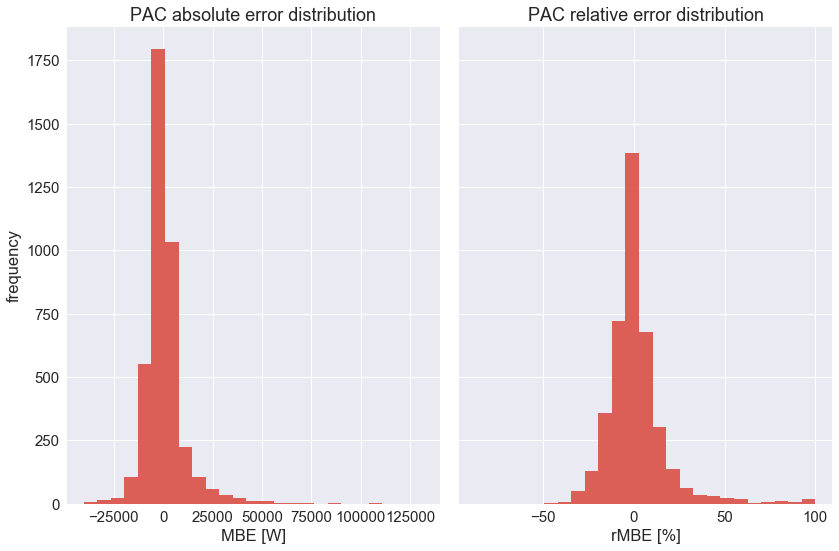

In [19]:
# plot the distribution of the error, to see if it is Gaussian?
f, ax = plt.subplots(1, 2, sharey=True)
comparison.MBE.hist(ax=ax[0], bins=25)
ax[0].set_title('PAC absolute error distribution')
xlim = 100
comparison.rMBE[comparison.rMBE.abs() < xlim].hist(ax=ax[1], bins=25)
ax[1].set_title('PAC relative error distribution')
ax[0].set_xlabel('MBE [W]')
ax[1].set_xlabel('rMBE [%]')
ax[0].set_ylabel('frequency')
plt.tight_layout()

## Annual MBE and RMSE
The annual MBE and RMSE are reported in the table below.

In [20]:
# calculate annual MBE, RMSE, rMBE, and rRMSE
annual_pac_sf_avg = comparison['Output Power'].mean()
annual_MBE = comparison.MBE.mean()
annual_rMBE = annual_MBE / annual_pac_sf_avg * 100
annual_RMSE = np.sqrt(comparison.RMSE.mean())
annual_rRMSE = np.sqrt(comparison.RMSE.mean()) / annual_pac_sf_avg * 100
annual = pd.DataFrame(
    {
        'AvgPac_SF[kW]': [annual_pac_sf_avg/1e3, 100],
        'MBE': [annual_MBE, annual_rMBE],
        'RMSE': [annual_RMSE, annual_rRMSE]
    },
    index=['abs.[W]', 'rel.[%]']
)
# display
annual

,AvgPac_SF[kW],MBE,RMSE
abs.[W],92.477287,605.765817,10510.537622
rel.[%],100.000000,0.655043,11.365534


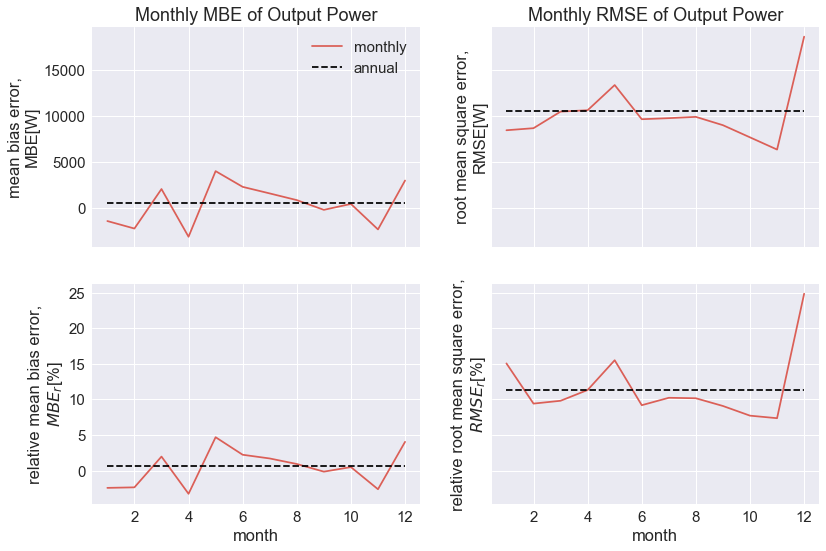

In [21]:
# plot comparison of inverter output
monthly_mbe = comparison.MBE.groupby(comparison.month).mean()
monthly_rmse = np.sqrt(comparison.RMSE.groupby(comparison.month).mean())
monthly_pac_sf_avg = comparison['Output Power'].groupby(comparison.month).mean()
monthly_mbe_r = monthly_mbe / monthly_pac_sf_avg * 100
monthly_rmse_r = monthly_rmse / monthly_pac_sf_avg * 100
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
ax[0].plot(monthly_mbe)
ax[0].plot(monthly_mbe.index,[annual_MBE]*monthly_mbe.index.size, 'k--')
ax[1].plot(monthly_rmse)
ax[1].plot(monthly_rmse.index,[annual_RMSE]*monthly_rmse.index.size, 'k--')
ax[2].plot(monthly_mbe_r)
ax[2].plot(monthly_mbe_r.index,[annual_rMBE]*monthly_mbe_r.index.size, 'k--')
ax[3].plot(monthly_rmse_r)
ax[3].plot(monthly_rmse_r.index,[annual_rRMSE]*monthly_rmse_r.index.size, 'k--')
ax[0].legend(['monthly', 'annual'])
ax[0].set_title('Monthly MBE of Output Power')
ax[1].set_title('Monthly RMSE of Output Power')
ax[2].set_xlabel('month')
ax[3].set_xlabel('month')
ax[0].set_ylabel('mean bias error,\nMBE[W]')
ax[1].set_ylabel('root mean square error,\nRMSE[W]')
ax[2].set_ylabel('relative mean bias error,\n$MBE_r$[%]')
ax[3].set_ylabel('relative root mean square error,\n$RMSE_r$[%]')
f.tight_layout()

In [22]:
# make a table of MBE and RMSE
monthly = pd.DataFrame(
    {'AvgPac_SF[kW]': monthly_pac_sf_avg/1e3,
     'MBE[W]': monthly_mbe, 'RMSE[W]': monthly_rmse,
     'rMBE[%]': monthly_mbe_r, 'rRMSE[%]': monthly_rmse_r}
)
# display
monthly

,AvgPac_SF[kW],MBE[W],RMSE[W],rMBE[%],rRMSE[%]
month,,,,,
1,56.149752,-1368.733770,8463.243588,-2.437649,15.072629
2,92.225961,-2179.494536,8687.428914,-2.363212,9.419722
3,106.772069,2097.170917,10481.902504,1.964157,9.817083
4,93.812600,-3068.541192,10632.128647,-3.270926,11.333370
5,86.062029,4037.177591,13358.834516,4.691009,15.522333
6,105.057454,2333.975823,9658.778823,2.221618,9.193806
7,95.463821,1622.225091,9773.515159,1.699309,10.237926
8,97.471301,899.188225,9912.769628,0.922516,10.169937
9,99.210483,-154.966046,9011.618254,-0.156199,9.083333


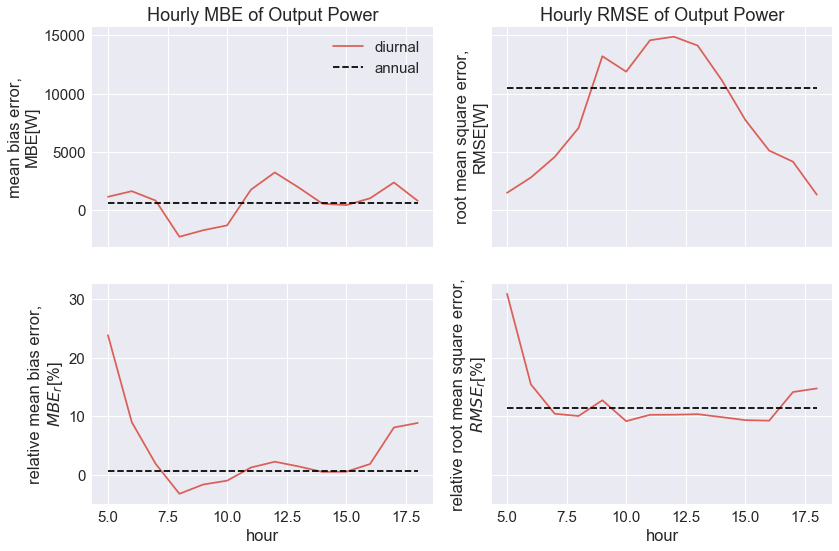

In [23]:
# plot comparison of inverter output
diurnal_mbe = comparison.MBE.groupby(comparison.hour).mean()
diurnal_rmse = np.sqrt(comparison.RMSE.groupby(comparison.hour).mean())
diurnal_pac_sf_avg = comparison['Output Power'].groupby(comparison.hour).mean()
diurnal_mbe_r = diurnal_mbe / diurnal_pac_sf_avg * 100
diurnal_rmse_r = diurnal_rmse / diurnal_pac_sf_avg * 100
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
ax[0].plot(diurnal_mbe)
ax[0].plot(diurnal_mbe.index,[annual_MBE]*diurnal_mbe.index.size, 'k--')
ax[1].plot(diurnal_rmse)
ax[1].plot(diurnal_rmse.index,[annual_RMSE]*diurnal_rmse.index.size, 'k--')
ax[2].plot(diurnal_mbe_r)
ax[2].plot(diurnal_mbe_r.index,[annual_rMBE]*diurnal_mbe_r.index.size, 'k--')
ax[3].plot(diurnal_rmse_r)
ax[3].plot(diurnal_rmse_r.index,[annual_rRMSE]*diurnal_rmse_r.index.size, 'k--')
ax[0].legend(['diurnal', 'annual'])
ax[0].set_title('Hourly MBE of Output Power')
ax[1].set_title('Hourly RMSE of Output Power')
ax[2].set_xlabel('hour')
ax[3].set_xlabel('hour')
ax[0].set_ylabel('mean bias error,\nMBE[W]')
ax[1].set_ylabel('root mean square error,\nRMSE[W]')
ax[2].set_ylabel('relative mean bias error,\n$MBE_r$[%]')
ax[3].set_ylabel('relative root mean square error,\n$RMSE_r$[%]')
f.tight_layout()

In [24]:
# make a table of MBE and RMSE
diurnal = pd.DataFrame(
    {'AvgPac_SF[kW]': diurnal_pac_sf_avg/1e3,
     'MBE[W]': diurnal_mbe, 'RMSE[W]': diurnal_rmse,
     'rMBE[%]': diurnal_mbe_r, 'rRMSE[%]': diurnal_rmse_r}
)
# display
diurnal

,AvgPac_SF[kW],MBE[W],RMSE[W],rMBE[%],rRMSE[%]
hour,,,,,
5,4.810378,1146.233695,1486.097454,23.828348,30.893567
6,18.140915,1627.630872,2800.376547,8.972154,15.436799
7,43.830915,821.337868,4565.446848,1.873878,10.416043
8,70.268493,-2280.994613,7048.859293,-3.246113,10.031323
9,103.871833,-1721.904120,13203.583986,-1.657720,12.711419
10,129.829873,-1306.879682,11878.248740,-1.006609,9.149088
11,142.403968,1757.187280,14573.828008,1.233945,10.234145
12,145.179289,3235.124598,14879.634468,2.228365,10.249144
13,136.490256,1945.945972,14114.372818,1.425703,10.340938


## Auto Correlation
To see if there is any systematic relation between the bias and the dependent variable, AC output power, we plot the MBE and RMSE versus the dependent variable. If the error is uncorrelated then there should be a random distribution.

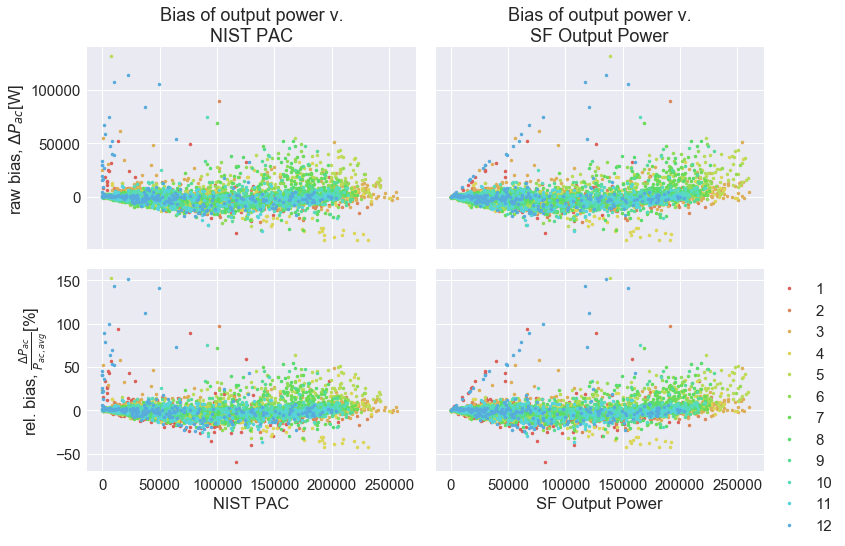

In [25]:
# Auto validation of output power versus shaded irradiance
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
for m in monthly_pac_sf_avg.index:
    midx = comparison.month == m
    ax[0].plot(comparison.PAC_GND[midx] * 1000.0, comparison.MBE[midx], '.')
    ax[1].plot(comparison['Output Power'][midx], comparison.MBE[midx], '.')
    ax[2].plot(comparison.PAC_GND[midx] * 1000.0, comparison.MBE[midx] / monthly_pac_sf_avg[m] * 100, '.')
    ax[3].plot(comparison['Output Power'][midx], comparison.MBE[midx]  / monthly_pac_sf_avg[m] * 100, '.')
plt.legend(monthly_pac_sf_avg.index, loc='upper right', bbox_to_anchor=(1.25, 1.0))
ax[0].set_title('Bias of output power v.\nNIST PAC')
ax[1].set_title('Bias of output power v.\nSF Output Power')
ax[2].set_xlabel('NIST PAC')
ax[3].set_xlabel('SF Output Power')
ax[0].set_ylabel('raw bias, $\Delta P_{ac}$[W]')
ax[2].set_ylabel('rel. bias, $\\frac{\\Delta P_{ac}}{P_{ac,avg}}$[%]')
f.tight_layout()

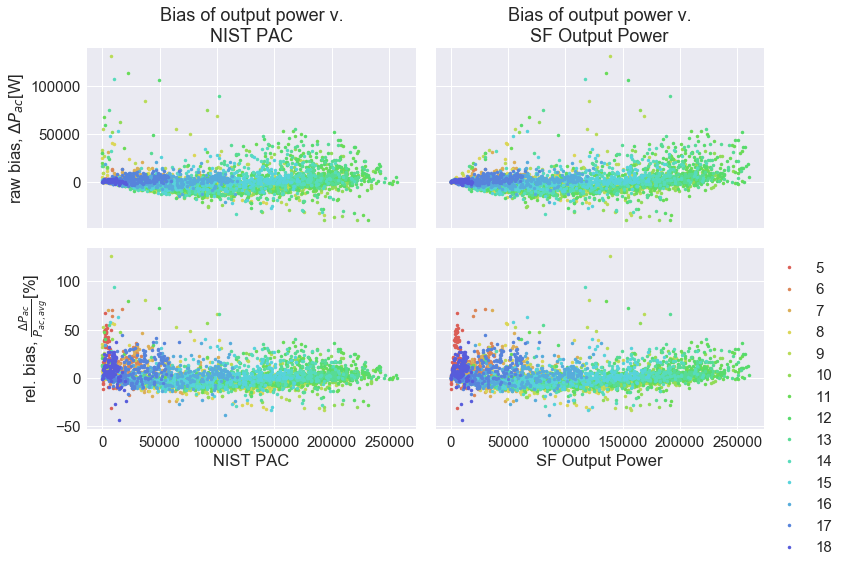

In [26]:
# Auto validation of output power versus shaded irradiance
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
for h in diurnal_pac_sf_avg.index:
    hidx = comparison.hour == h
    ax[0].plot(comparison.PAC_GND[hidx] * 1000.0, comparison.MBE[hidx], '.')
    ax[1].plot(comparison['Output Power'][hidx], comparison.MBE[hidx], '.')
    ax[2].plot(comparison.PAC_GND[hidx] * 1000.0, comparison.MBE[hidx] / diurnal_pac_sf_avg[h] * 100, '.')
    ax[3].plot(comparison['Output Power'][hidx], comparison.MBE[hidx] / diurnal_pac_sf_avg[h] * 100, '.')
ax[3].legend(diurnal_pac_sf_avg.index, loc='upper right', bbox_to_anchor=(1.25, 1.0))
ax[0].set_title('Bias of output power v.\nNIST PAC')
ax[1].set_title('Bias of output power v.\nSF Output Power')
ax[2].set_xlabel('NIST PAC')
ax[3].set_xlabel('SF Output Power')
ax[0].set_ylabel('raw bias, $\Delta P_{ac}$[W]')
ax[2].set_ylabel('rel. bias, $\\frac{\\Delta P_{ac}}{P_{ac,avg}}$[%]')
f.tight_layout()

## Cross Correlation
To see if there is any systematic relation between the bias and any of the independent variables like temperature or irradiance, we plot the MBE and RMSE versus the independent variables. If the error is uncorrelated then there should be a random distribution.

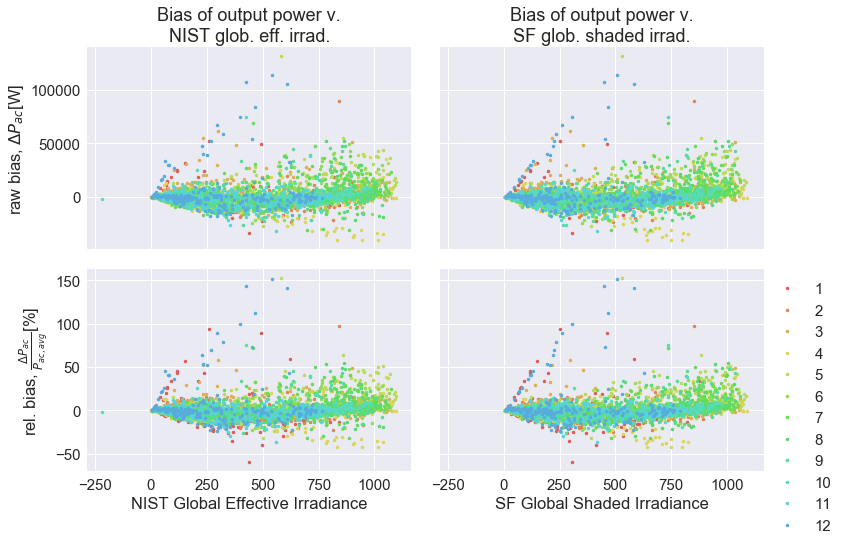

In [27]:
# Cross validation of output power versus shaded irradiance
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
for m in monthly_pac_sf_avg.index:
    midx = comparison.month == m
    ax[0].plot(comparison.POA_GND[midx], comparison.MBE[midx], '.')
    ax[1].plot(comparison.ShadedIrradiance[midx], comparison.MBE[midx], '.')
    ax[2].plot(comparison.POA_GND[midx], comparison.MBE[midx] / monthly_pac_sf_avg[m] * 100, '.')
    ax[3].plot(comparison.ShadedIrradiance[midx], comparison.MBE[midx]  / monthly_pac_sf_avg[m] * 100, '.')
plt.legend(monthly_pac_sf_avg.index, loc='upper right', bbox_to_anchor=(1.25, 1.0))
ax[0].set_title('Bias of output power v.\nNIST glob. eff. irrad.')
ax[1].set_title('Bias of output power v.\nSF glob. shaded irrad.')
ax[2].set_xlabel('NIST Global Effective Irradiance')
ax[3].set_xlabel('SF Global Shaded Irradiance')
ax[0].set_ylabel('raw bias, $\Delta P_{ac}$[W]')
ax[2].set_ylabel('rel. bias, $\\frac{\\Delta P_{ac}}{P_{ac,avg}}$[%]')
f.tight_layout()

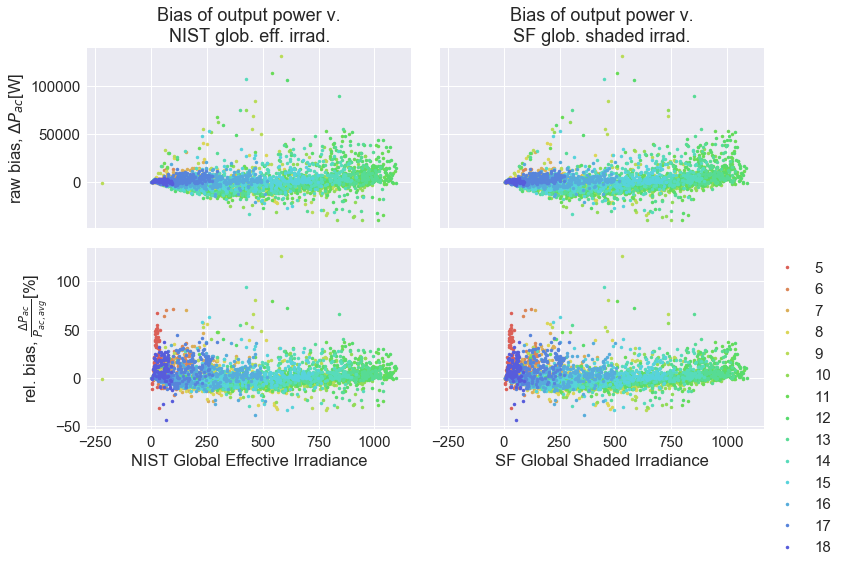

In [28]:
# Cross validation of output power versus shaded irradiance
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
for h in diurnal_pac_sf_avg.index:
    hidx = comparison.hour == h
    ax[0].plot(comparison.POA_GND[hidx], comparison.MBE[hidx], '.')
    ax[1].plot(comparison.ShadedIrradiance[hidx], comparison.MBE[hidx], '.')
    ax[2].plot(comparison.POA_GND[hidx], comparison.MBE[hidx] / diurnal_pac_sf_avg[h] * 100, '.')
    ax[3].plot(comparison.ShadedIrradiance[hidx], comparison.MBE[hidx] / diurnal_pac_sf_avg[h] * 100, '.')
ax[3].legend(diurnal_pac_sf_avg.index, loc='upper right', bbox_to_anchor=(1.25, 1.25))
ax[0].set_title('Bias of output power v.\nNIST glob. eff. irrad.')
ax[1].set_title('Bias of output power v.\nSF glob. shaded irrad.')
ax[2].set_xlabel('NIST Global Effective Irradiance')
ax[3].set_xlabel('SF Global Shaded Irradiance')
ax[0].set_ylabel('raw bias, $\Delta P_{ac}$[W]')
ax[2].set_ylabel('rel. bias, $\\frac{\\Delta P_{ac}}{P_{ac,avg}}$[%]')
f.tight_layout()

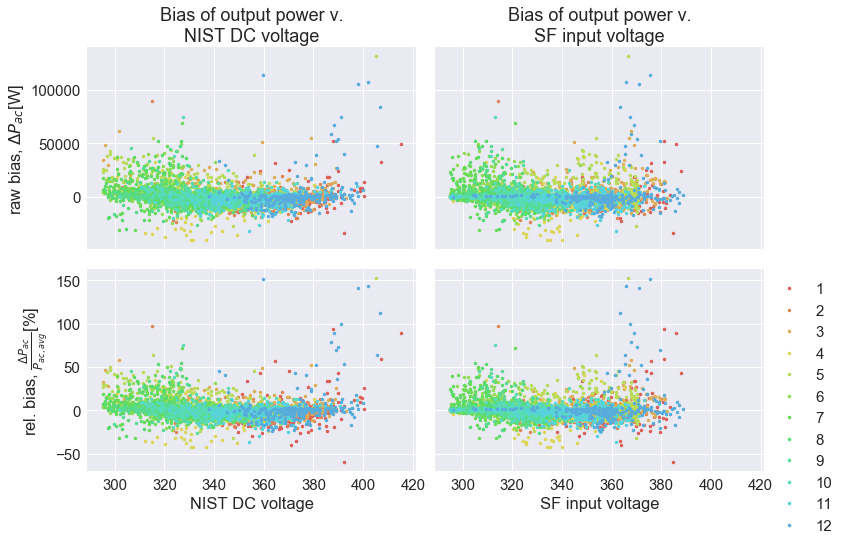

In [45]:
# Cross validation of output power versus shaded irradiance
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
for m in monthly_pac_sf_avg.index:
    midx = comparison.month == m
    ax[0].plot(comparison.VDC_GND[midx], comparison.MBE[midx], '.')
    ax[1].plot(comparison['Input Voltage'][midx], comparison.MBE[midx], '.')
    ax[2].plot(comparison.VDC_GND[midx], comparison.MBE[midx] / monthly_pac_sf_avg[m] * 100, '.')
    ax[3].plot(comparison['Input Voltage'][midx], comparison.MBE[midx]  / monthly_pac_sf_avg[m] * 100, '.')
plt.legend(monthly_pac_sf_avg.index, loc='upper right', bbox_to_anchor=(1.25, 1.0))
ax[0].set_title('Bias of output power v.\nNIST DC voltage')
ax[1].set_title('Bias of output power v.\nSF input voltage')
ax[2].set_xlabel('NIST DC voltage')
ax[3].set_xlabel('SF input voltage')
ax[0].set_ylabel('raw bias, $\Delta P_{ac}$[W]')
ax[2].set_ylabel('rel. bias, $\\frac{\\Delta P_{ac}}{P_{ac,avg}}$[%]')
f.tight_layout()

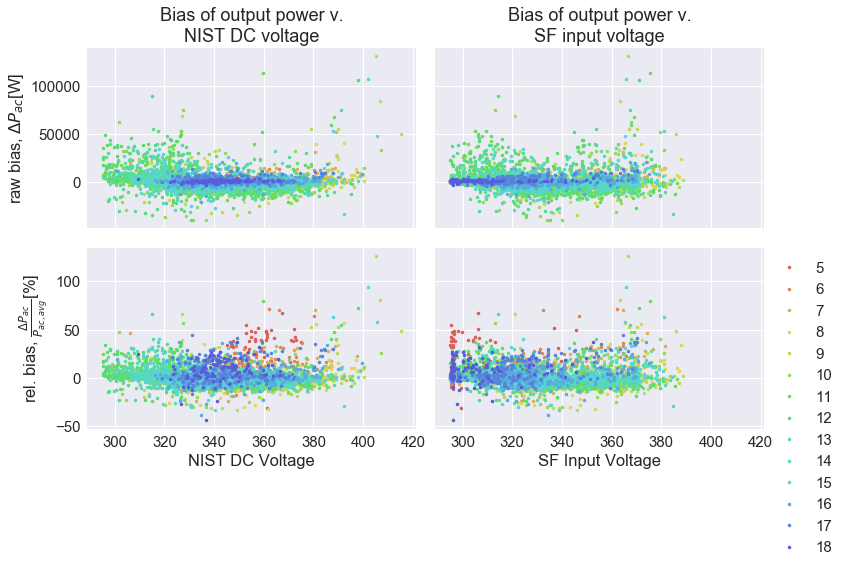

In [48]:
# Cross validation of output power versus shaded irradiance
f, ax = plt.subplots(2, 2, sharex=True, sharey='row')
ax = ax.flatten()
for h in diurnal_pac_sf_avg.index:
    hidx = comparison.hour == h
    ax[0].plot(comparison.VDC_GND[hidx], comparison.MBE[hidx], '.')
    ax[1].plot(comparison['Input Voltage'][hidx], comparison.MBE[hidx], '.')
    ax[2].plot(comparison.VDC_GND[hidx], comparison.MBE[hidx] / diurnal_pac_sf_avg[h] * 100, '.')
    ax[3].plot(comparison['Input Voltage'][hidx], comparison.MBE[hidx] / diurnal_pac_sf_avg[h] * 100, '.')
ax[3].legend(diurnal_pac_sf_avg.index, loc='upper right', bbox_to_anchor=(1.25, 1.0))
ax[0].set_title('Bias of output power v.\nNIST DC voltage')
ax[1].set_title('Bias of output power v.\nSF input voltage')
ax[2].set_xlabel('NIST DC Voltage')
ax[3].set_xlabel('SF Input Voltage')
ax[0].set_ylabel('raw bias, $\Delta P_{ac}$[W]')
ax[2].set_ylabel('rel. bias, $\\frac{\\Delta P_{ac}}{P_{ac,avg}}$[%]')
f.tight_layout()

In [29]:
# aggregate daily averages
mean_daily_comparison = comparison.groupby('doy').mean()
mean_daily_comparison['month'] = mean_daily_comparison.month.astype('int')
# mean daily relative bais
mean_daily_comparison['rMBE'] = mean_daily_comparison.MBE / mean_daily_comparison['Output Power'] * 100

In [30]:
mean_daily_comparison = mean_daily_comparison[['month', 'MBE', 'rMBE']]

Text(0.5,1,'comparison of bias by month in watts [W]')

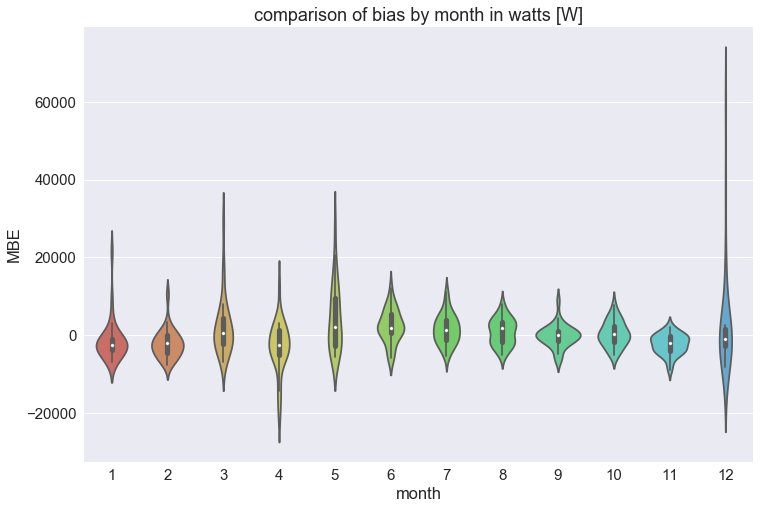

In [31]:
# box plot of monthly bias
ax = sns.violinplot(x="month", y="MBE", data=mean_daily_comparison)
plt.title('comparison of bias by month in watts [W]')

Text(0.5,1,'comparison of relative bias by month in percent [%]')

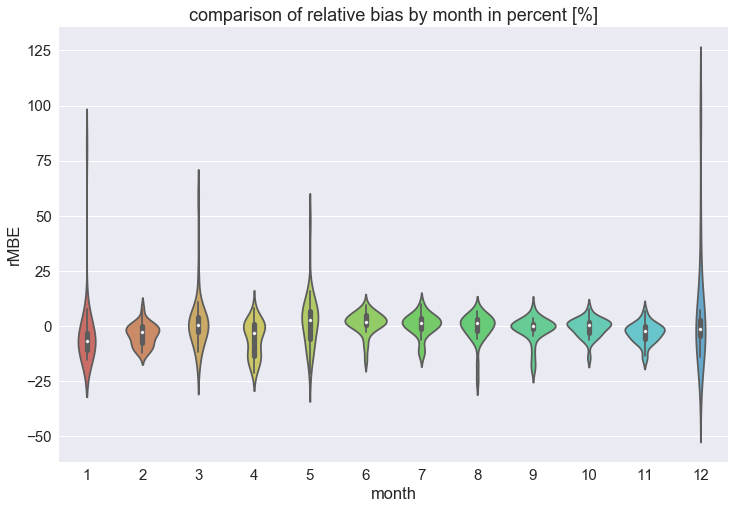

In [32]:
# box plot of monthly relative bias
ax = sns.violinplot(x="month", y="rMBE", data=mean_daily_comparison)
plt.title('comparison of relative bias by month in percent [%]')

In [33]:
# pivot table of mean monthly comparison by hour
lil_comp = comparison[['month', 'hour', 'MBE', 'Output Power']]
monthly_pivot_comparison = lil_comp.pivot_table(index='month', columns='hour', aggfunc='mean')
# display MBE in kilowatts
monthly_pivot_comparison['MBE']/1e3

hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18
month,,,,,,,,,,,,,,
1,NaN,NaN,NaN,1.572633,0.329199,-3.224541,-4.477462,-3.206034,-3.988640,-2.445069,1.535724,2.023264,NaN,NaN
2,NaN,NaN,3.662305,-0.700693,-5.351750,-6.086488,-6.118542,-2.975358,0.262279,-2.425106,-0.980929,1.976538,-0.154154,NaN
3,NaN,0.133333,4.032625,-0.396733,-1.771677,1.525878,2.194446,5.879275,3.619623,1.857466,0.870295,1.787608,3.785907,NaN
4,NaN,1.876521,-1.318604,-7.653367,-7.348868,-8.151107,-4.642826,-0.065252,-3.109838,-3.294739,-3.343151,-1.580719,1.739120,-2.013491
5,0.973270,2.017939,-0.749241,-1.820639,6.959160,4.511674,6.804397,8.373950,9.159096,7.004836,5.411967,3.622720,2.550355,0.905811
6,1.227852,1.656732,-1.562487,-4.905270,-1.156317,2.090896,8.365830,7.038388,7.749142,4.386972,2.567175,0.622411,3.541290,1.053047
7,1.188122,1.967734,-0.773866,-5.289224,0.632483,2.207979,8.105523,7.649915,3.965936,0.864250,-0.417701,-0.396518,2.040645,0.811837
8,NaN,1.027793,-0.541469,-4.192318,-4.507600,-1.719584,7.539334,9.221545,5.550364,1.102687,-1.631752,-1.894386,1.080764,0.477039
9,NaN,1.402442,0.617798,-5.558426,-4.616364,-2.593059,2.995788,4.221089,0.433188,-0.504612,-1.250661,1.757693,1.901620,NaN


Text(0,0.5,'MBE [W]')

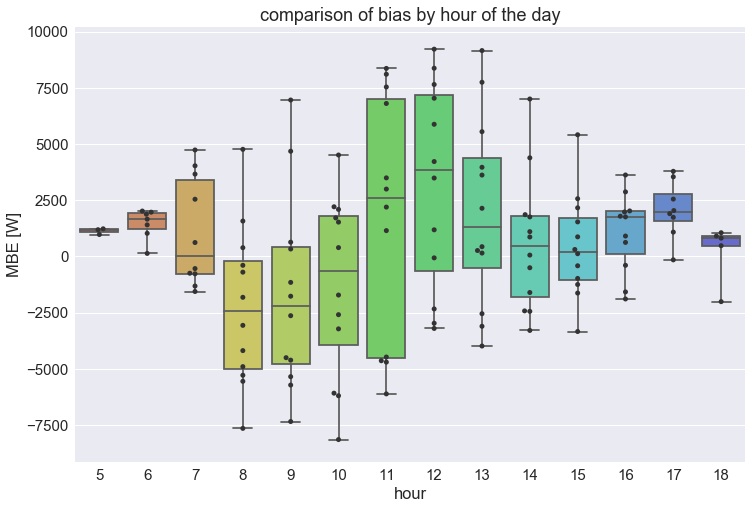

In [34]:
# box plot of hour of day bias
ax = sns.boxplot(data=monthly_pivot_comparison['MBE'], whis=np.inf)
ax = sns.swarmplot(data=monthly_pivot_comparison['MBE'], color='0.2')
plt.title('comparison of bias by hour of the day')
plt.xlabel('hour')
plt.ylabel('MBE [W]')

In [35]:
# pivot table of monthly mean average output power by hour
monthly_pivot_PacSF = monthly_pivot_comparison['Output Power']
# display SolarFarmer AC output power in kilowatts
monthly_pivot_PacSF/1e3

hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18
month,,,,,,,,,,,,,,
1,NaN,NaN,NaN,15.459090,44.937712,66.076045,82.992839,92.884998,76.328048,65.425279,41.262160,14.623353,NaN,NaN
2,NaN,NaN,15.823014,45.097173,84.121644,116.697824,127.740024,131.635094,127.268236,105.821301,87.086897,43.332034,0.000000,NaN
3,NaN,3.054510,26.253463,71.641691,107.650137,141.990289,166.583263,178.137780,168.147782,144.996903,100.930539,61.737494,17.208951,NaN
4,NaN,11.590113,41.822785,75.985953,110.350437,145.008868,155.802808,153.970354,144.925962,123.752529,86.711346,58.311254,23.217127,8.337618
5,4.066041,22.487284,56.734870,88.503817,119.172213,139.365298,147.062850,146.534364,142.413826,122.099520,97.871900,60.769537,29.604683,5.934502
6,5.810048,29.039777,70.710076,110.020826,140.397336,169.997414,178.267050,175.421383,174.253313,149.719885,122.365524,87.519679,45.812131,11.469910
7,4.017995,22.520658,60.915807,102.881083,133.909407,154.923860,167.827926,159.342798,148.652320,121.111408,106.017687,70.887880,40.124183,10.911962
8,NaN,15.074073,50.181317,88.586476,121.228445,148.287343,160.370511,161.753615,151.656477,123.594789,96.204277,72.762723,32.694103,6.643817
9,NaN,8.667282,46.260875,87.845252,122.153838,145.775284,149.334065,156.675289,147.070438,130.196332,94.799131,55.358032,15.963142,NaN


In [36]:
# pivot table of mean monthly relative bias by hour
monthly_pivot_rmbe = monthly_pivot_comparison['MBE'] / monthly_pivot_PacSF * 100  # [%]
# display relative bias in percent
monthly_pivot_rmbe

hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18
month,,,,,,,,,,,,,,
1,NaN,NaN,NaN,10.172870,0.732567,-4.880046,-5.394998,-3.451617,-5.225654,-3.737193,3.721871,13.835841,NaN,NaN
2,NaN,NaN,23.145432,-1.553740,-6.361918,-5.215597,-4.789840,-2.260308,0.206084,-2.291699,-1.126379,4.561379,-inf,NaN
3,NaN,4.365109,15.360354,-0.553774,-1.645773,1.074635,1.317327,3.300409,2.152644,1.281039,0.862271,2.895498,21.999641,NaN
4,NaN,16.190707,-3.152837,-10.072082,-6.659574,-5.621109,-2.979938,-0.042380,-2.145812,-2.662361,-3.855494,-2.710830,7.490679,-24.149474
5,23.936540,8.973688,-1.320601,-2.057130,5.839583,3.237301,4.626863,5.714666,6.431325,5.736989,5.529643,5.961408,8.614701,15.263467
6,21.133257,5.705044,-2.209710,-4.458492,-0.823604,1.229957,4.692864,4.012275,4.447056,2.930120,2.097956,0.711167,7.730027,9.180956
7,29.570017,8.737464,-1.270386,-5.141104,0.472322,1.425202,4.829663,4.800917,2.667927,0.713599,-0.393992,-0.559360,5.085823,7.439882
8,NaN,6.818285,-1.079026,-4.732458,-3.718269,-1.159629,4.701197,5.700982,3.659827,0.892179,-1.696133,-2.603512,3.305683,7.180201
9,NaN,16.180877,1.335465,-6.327520,-3.779140,-1.778806,2.006098,2.694164,0.294544,-0.387578,-1.319274,3.175137,11.912569,NaN


Text(0,0.5,'MBE [%]')

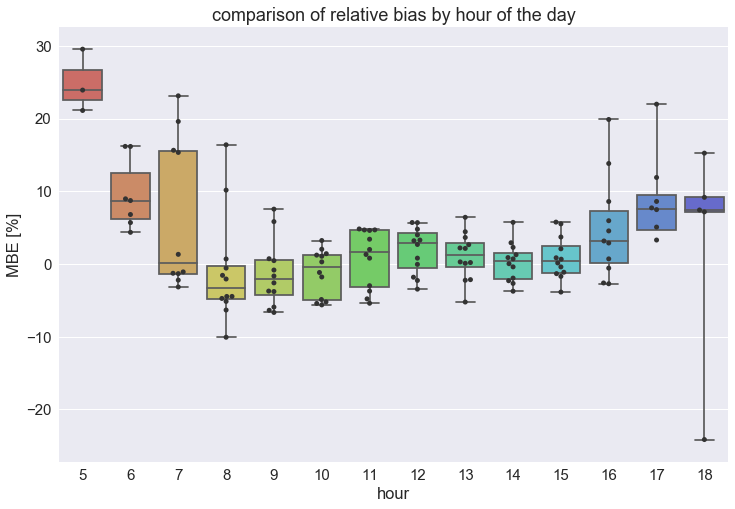

In [37]:
# box plot of hour of day bias
ax = sns.boxplot(data=monthly_pivot_rmbe, whis=np.inf)
ax = sns.swarmplot(data=monthly_pivot_rmbe, color='0.2')
plt.title('comparison of relative bias by hour of the day')
plt.xlabel('hour')
plt.ylabel('MBE [%]')

Text(0,0.5,'month of year')

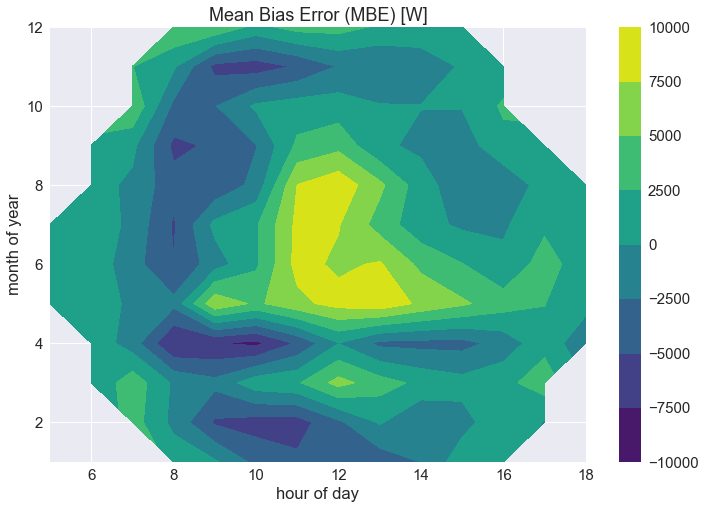

In [38]:
# make a 12x24 contour plot
mbe_pivot = monthly_pivot_comparison.MBE
plt.contourf(mbe_pivot.columns, mbe_pivot.index, mbe_pivot, cmap='viridis')
plt.colorbar()
plt.title('Mean Bias Error (MBE) [W]')
plt.xlabel('hour of day')
plt.ylabel('month of year')

Text(0,0.5,'month of year')

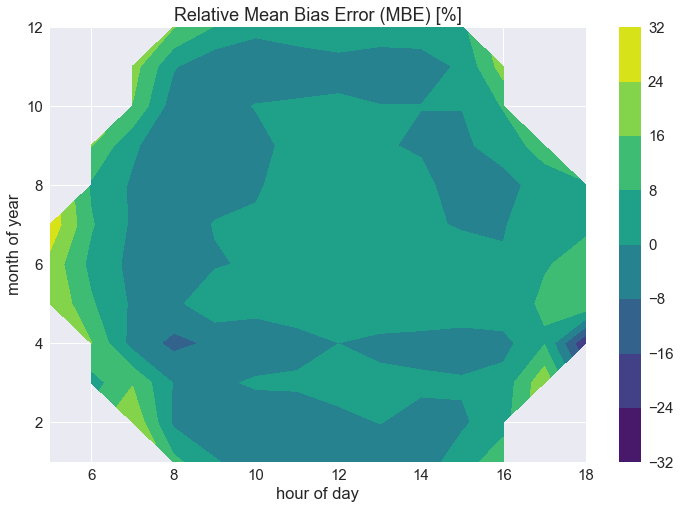

In [39]:
# make a 12x24 contour plot
plt.contourf(monthly_pivot_rmbe.columns, monthly_pivot_rmbe.index, monthly_pivot_rmbe, cmap='viridis')
plt.colorbar()
plt.title('Relative Mean Bias Error (MBE) [%]')
plt.xlabel('hour of day')
plt.ylabel('month of year')

# More Boxplots
The box plots above were aggregated by day for monthly boxplots, and by month for hourly boxplots to smooth some of the noise from relative errors, and from different solar positions during the year. The boxplots below are not aggregated, so they show the distribution for the entire year, which exagerates some outliers and changes the distributions because the aggregated distributions have different weights because they are aggregated over different times. EG: Since monthly boxplots are aggregated over day of the year, some months have more days than others.

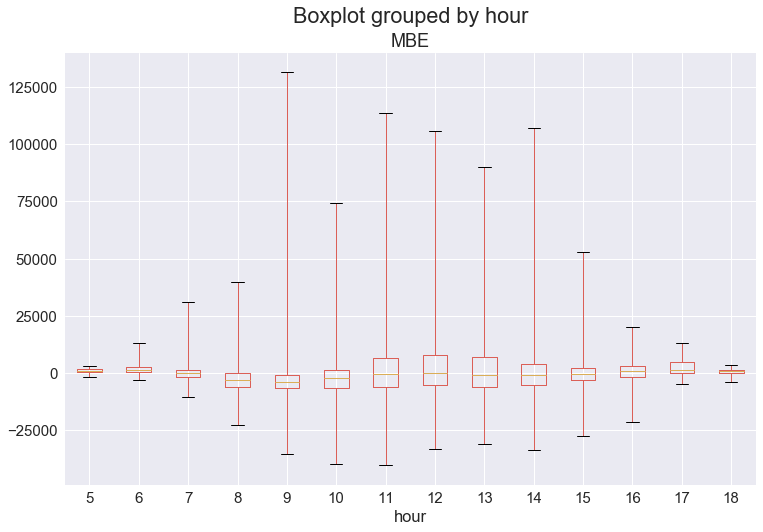

In [40]:
comparison.boxplot(column='MBE', by='hour', whis=np.inf)

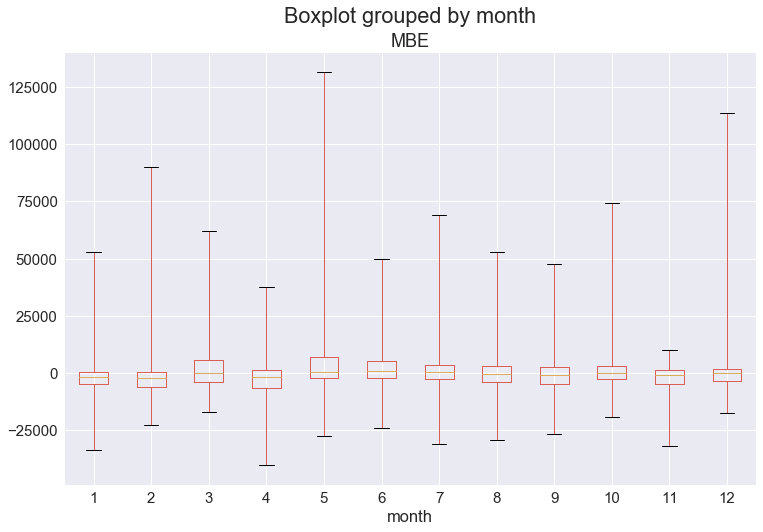

In [41]:
comparison.boxplot(column='MBE', by='month', whis=np.inf)

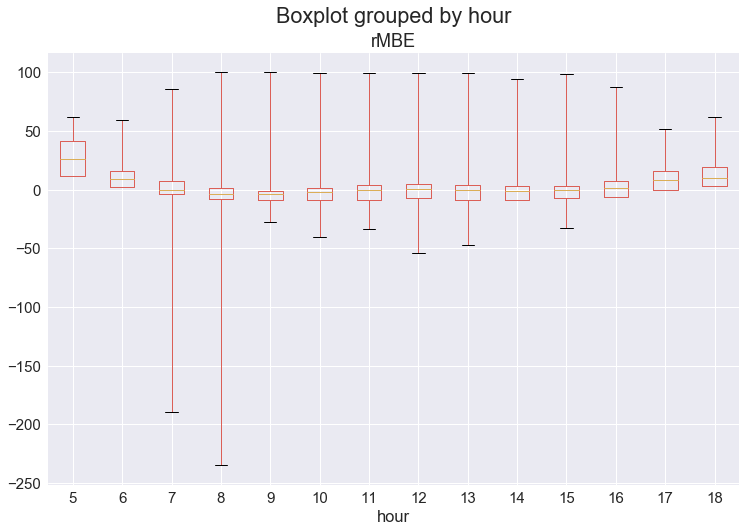

In [42]:
comparison.boxplot(column='rMBE', by='hour', whis=np.inf)

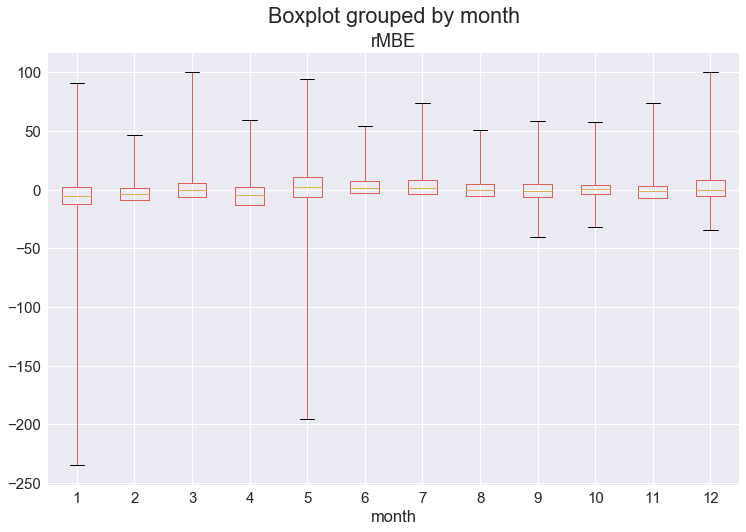

In [43]:
comparison.boxplot(column='rMBE', by='month', whis=np.inf)